Detail Perform ARM using product, aisle, and department as the item.

To perform an ARM with item=product we need to reduce the number of products (from the initial 50K products). A crude approach is to simply drop all product which appear less than some minimum frequency threshold (say PRODUCT_KEEP_MIN_FREQ=500).

The table orders_products needs to be one-hot encoded. Simplest way to do this is to first convert the order-product pairs to a transaction list and then (as in Practical B) to a one-hot encoding.

convert table of (order,product) pairs to list of transactions transactions = orders_products.groupby('order_id').apply(lambda order: order['product_id'].tolist()) For each ARM with item (product, aisle, department) you should at least do the following subtasks:

Visualise the first 100 transactions vs items and comment (see Practical B). Visualise the distribution of transaction size and comment (see Practical B). Generate a few hundred frequent itemsets. You need to experiment (as discussed in class) to estimate a suitable value for the support threshold. Generate a hundred+ rules and see if your can identify any interesting ones. Disclaimers/Comments When using aisle and department for item in the ARM model, we really should be using more advanced models than just (0=absent, 1=present). Feel free to explore the more advanced models, but we would be happy with just the one-hot analysis.

When you perform ARM with item=product we will find the your rule list will swamped by the organic fanboy/girl customers (my term not Bernard's) and I realy hope those customers buying the {lemon,lime}{lemon,lime} itemset were doing it for non-healthy reasons like drinking gin!

A more sophisticated analysis with item=product would be to roll up (merge) essentially similar products. So

All the organic fruit ( Organic Strawberries,Organic Raspberries,Bag of Organic Bananas,…looong list…Organic Strawberries,Organic Raspberries,Bag of Organic Bananas,…looong list… ) would just go to "organic fruit" Merge products which differ only by brand name. Grading Outline 3 x 25% for each of the separate basic ARM with item = (product, aisle, department) where the 25% consists of 10% Visualisation 5% Rule generation 10% Comments/analysis and identification of interesting rules. 25% for performing some roll-up of products and a more sophisticated analysis.

# imports

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

from itertools import combinations, groupby
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import sys

# dataframes

In [2]:
orders_products_prior_full = pd.read_csv('instacart_2017_05_01/my_order_products__prior.csv')
orders_products_train_full = pd.read_csv('instacart_2017_05_01/my_order_products__train.csv')
orders_products = pd.concat([orders_products_prior_full, orders_products_train_full])

orders = pd.read_csv('instacart_2017_05_01/my_orders.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
departments = pd.read_csv('instacart_2017_05_01/departments.csv')

orders_a = pd.merge(orders, orders_products, on='order_id', how='inner').apply(lambda x: x)
columns = ['order_id', 'user_id', 'days_since_prior_order', 'product_id']
raw_data = pd.DataFrame(orders_a, columns=columns)
raw_data = pd.merge(raw_data, products, on='product_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, aisles, on='aisle_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, departments, on='department_id', how='left').apply(lambda x: x)
master_df = raw_data.copy()
print("Number of ordered products before/after merge : {} / {}".format(len(orders_products),len(master_df)))
master_df.head()

Number of ordered products before/after merge : 2374 / 2374


,order_id,user_id,days_since_prior_order,product_id,product_name,aisle_id,department_id,aisle,department
0,3308693,1886,NaN,42972,Natural Pure Sparkling Water,115,7,water seltzer sparkling water,beverages
1,3308693,1886,NaN,47977,Grapefruit Sparkling Water,115,7,water seltzer sparkling water,beverages
2,3308693,1886,NaN,30696,Eggo Homestyle Waffles,52,1,frozen breakfast,frozen
3,1019221,1886,6.0,9623,Sparkling Natural Spring Water,115,7,water seltzer sparkling water,beverages
4,1019221,1886,6.0,35914,Dha Omega 3 Reduced Fat 2% Milk,84,16,milk,dairy eggs


# Calculate top selling products

In [3]:
threshold = 18 #18 returns top 10 (11/876)
c = master_df["product_name"].value_counts().gt(threshold) 
top_ten_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_ten_products = top_ten_products_df["product_name"].unique()
print("{} products appear at least {} times".format(len(top_ten_products), threshold))

threshold = 13 #13 returns top 20 (21/876)
c = master_df["product_name"].value_counts().gt(threshold) 
top_twenty_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_twenty_products = top_twenty_products_df["product_name"].unique()
top_ten_to_twenty_products = [item for item in top_twenty_products_df["product_name"].unique() if item not in top_ten_products]
print("{} products appear at least {} times".format(len(top_twenty_products), threshold))

threshold = 8 #8 returns top 50 (53/876)
c = master_df["product_name"].value_counts().gt(threshold) 
top_fifty_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_fifty_products = top_fifty_products_df["product_name"].unique()
top_twenty_to_fifty_products = [item for item in top_fifty_products_df["product_name"].unique() if item not in top_twenty_products and item not in top_ten_products]
print("{} products appear at least {} times".format(len(top_fifty_products), threshold))

threshold = 4 #4 returns top 100 (123/876)
c = master_df["product_name"].value_counts().gt(threshold) 
top_hundred_products_df = master_df.loc[master_df["product_name"].isin(c[c].index)]
top_hundred_products = top_hundred_products_df["product_name"].unique()
top_fifty_to_hundred_products = [item for item in top_hundred_products_df["product_name"].unique() if item not in top_fifty_products and item not in top_twenty_products and item not in top_ten_products]
print("{} products appear at least {} times".format(len(top_hundred_products), threshold))

master_df["product_name"].value_counts().head()

11 products appear at least 18 times
21 products appear at least 13 times
53 products appear at least 8 times
123 products appear at least 4 times


Banana                          63
Bag of Organic Bananas          31
Natural Pure Sparkling Water    25
Organic Half & Half             24
Apple Honeycrisp Organic        23
Name: product_name, dtype: int64

# utility methods

In [4]:

def unique_product_mix(productmix):
    #filters out products that are not top sellers
    product_set = set([x if (x in top_twenty_products) else 'Other' for x in productmix.values])
    return list(product_set)

def unique_mix(mix):
    product_set = set(mix.values)
    return list(product_set)

def unique_mix_count(mix):   
    return len(list(mix))




In [5]:
product_mix_df = pd.DataFrame(master_df.groupby("order_id")['product_name'].apply(unique_product_mix))
product_mix_df["unique_items_in_cart"] = product_mix_df["product_name"].apply(unique_mix_count)

#product_mix_df = product_mix_df.loc[product_mix_df["unique_items_in_cart"] > 1]
product_mix_df.columns = ['product_mix', 'unique_items_in_cart']
product_mix_df.loc[product_mix_df["unique_items_in_cart"] > 1].sort_values("unique_items_in_cart",ascending=False).head()

,product_mix,unique_items_in_cart
order_id,,
3019942,"[Organic Sweet Mini Peppers, Tart Cherry Yoghu...",8
322157,"[Organic Sweet Mini Peppers, Tart Cherry Yoghu...",8
237760,"[Organic Sweet Mini Peppers, Apple Honeycrisp ...",8
892435,"[Apple Honeycrisp Organic, Hass Avocados, Peac...",7
2819427,"[Tart Cherry Yoghurt, Apple Honeycrisp Organic...",7


Unique Products per order ranges from 1 to 8


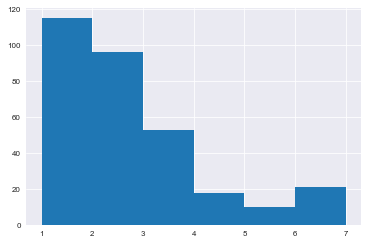

In [6]:
print("Unique Products per order ranges from {} to {}"
      .format(product_mix_df["unique_items_in_cart"].min(),product_mix_df["unique_items_in_cart"].max()))
plt.hist(product_mix_df["unique_items_in_cart"],bins=range(1,8))
plt.show()

In [7]:
te = TransactionEncoder()
te_ary = te.fit(product_mix_df["product_mix"]).transform(product_mix_df["product_mix"],sparse=False)

df = pd.DataFrame(te_ary, columns=te.columns_)
min_support = 0.01
frequent_itemsets = apriori(df, min_support=min_support,use_colnames=True).sort_values(by='support',ascending=False)
print("Generated {} frequest itemsets using a minimum support of {}".format(len(frequent_itemsets),min_support))
frequent_itemsets.head()

Generated 287 frequest itemsets using a minimum support of 0.01


,support,itemsets
19,0.981013,[Other]
2,0.199367,[Banana]
41,0.199367,"[Banana, Other]"
1,0.098101,[Bag of Organic Bananas]
30,0.085443,"[Bag of Organic Bananas, Other]"


In [8]:
confidence_min = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
rules.head()

print("Generated {} rules with minimum confidence {}".format(len(rules),confidence_min))
antecedent_max = 3
consequent_max = 3
confidence_min = 0.6
lift_min = 1.2

filtered_rules = rules[ (rules['antecedant_len'] <= antecedent_max ) &
               (rules['consequents_len'] <= consequent_max ) &
               (rules['confidence'] > confidence_min) &
               (rules['lift'] > lift_min) ]
print("Filtered {} rules to {} rules using filters [antecedent_max: {}, consequent_max: {}, confidence_min: {}, lift_min: {}]"
      .format(len(rules),len(filtered_rules),4,4,5,6))
filtered_rules.sort_values(by='lift',ascending=False).drop(['antecedant_len', 'consequents_len','antecedent support', 'consequent support'], axis=1).head(n=20)

Generated 1323 rules with minimum confidence 0.5
Filtered 1323 rules to 637 rules using filters [antecedent_max: 4, consequent_max: 4, confidence_min: 5, lift_min: 6]


,antecedants,consequents,support,confidence,lift,leverage,conviction
823,"(Organic Greek Lowfat Yogurt With Cherries, Or...","(Organic Bartlett Pear, Tart Cherry Yoghurt, B...",0.012658,0.666667,42.133333,0.012358,2.952532
1256,"(Organic Bartlett Pear, Tart Cherry Yoghurt)","(Organic Greek Lowfat Yogurt With Cherries, Or...",0.012658,0.800000,42.133333,0.012358,4.905063
1044,"(Other, Organic Greek Lowfat Yogurt With Cherr...","(Organic Bartlett Pear, Tart Cherry Yoghurt)",0.012658,0.666667,42.133333,0.012358,2.952532
1045,"(Organic Bartlett Pear, Tart Cherry Yoghurt)","(Other, Organic Greek Lowfat Yogurt With Cherr...",0.012658,0.800000,42.133333,0.012358,4.905063
1048,"(Organic Greek Lowfat Yogurt With Cherries, Or...","(Organic Bartlett Pear, Other, Tart Cherry Yog...",0.012658,0.666667,42.133333,0.012358,2.952532
820,"(Organic Bartlett Pear, Tart Cherry Yoghurt)","(Organic Greek Lowfat Yogurt With Cherries, Ba...",0.012658,0.800000,42.133333,0.012358,4.905063
819,"(Organic Greek Lowfat Yogurt With Cherries, Ba...","(Organic Bartlett Pear, Tart Cherry Yoghurt)",0.012658,0.666667,42.133333,0.012358,2.952532
1037,"(Organic Bartlett Pear, Other, Tart Cherry Yog...","(Organic Greek Lowfat Yogurt With Cherries, Or...",0.012658,0.800000,42.133333,0.012358,4.905063
814,"(Organic Bartlett Pear, Tart Cherry Yoghurt, B...","(Organic Greek Lowfat Yogurt With Cherries, Or...",0.012658,0.800000,42.133333,0.012358,4.905063
1259,"(Organic Greek Lowfat Yogurt With Cherries, Or...","(Organic Bartlett Pear, Tart Cherry Yoghurt)",0.012658,0.666667,42.133333,0.012358,2.952532


# roll up to aisle

In [9]:
aisle_mix_df = pd.DataFrame(master_df.groupby("order_id")['aisle'].apply(list))
aisle_mix_df.head()

,aisle
order_id,
8938,"[cream, cereal, fruit vegetable snacks, candy ..."
35204,"[water seltzer sparkling water, butter, butter..."
36495,"[fresh fruits, fresh fruits, packaged produce,..."
40262,"[prepared meals, marinades meat preparation, b..."
54652,"[buns rolls, buns rolls, soft drinks, packaged..."


In [10]:

aisle_mix_df["unique_items_in_cart"] = aisle_mix_df["aisle"].apply(unique_mix_count)
aisle_mix_df.columns = ['aisle_mix', 'unique_aisles_in_cart']
aisle_mix_df.loc[aisle_mix_df["unique_aisles_in_cart"] > 1].sort_values("unique_aisles_in_cart",ascending=False).head()
#how can there be an order with 31 unique aisles when the max number of unique products we saw in an order was 8?
#this is because we counted all products outside the top 100 as 'other'

,aisle_mix,unique_aisles_in_cart
order_id,,
274046,"[fresh vegetables, asian foods, oils vinegars,...",31
2112047,"[eggs, cookies cakes, fresh vegetables, chips ...",28
333779,"[preserved dips spreads, tofu meat alternative...",28
2601663,"[fresh fruits, fresh fruits, fresh dips tapena...",26
2991595,"[bread, milk, crackers, fresh fruits, fresh fr...",25


Unique Aisles per order ranges from 1 to 31


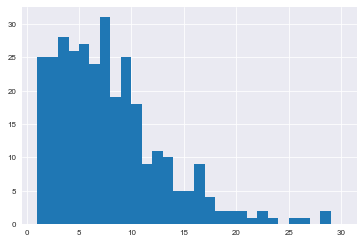

In [11]:
print("Unique Aisles per order ranges from {} to {}"
      .format(aisle_mix_df["unique_aisles_in_cart"].min(),aisle_mix_df["unique_aisles_in_cart"].max()))
plt.hist(aisle_mix_df["unique_aisles_in_cart"],bins=range(1,31))
plt.show()

In [12]:
te = TransactionEncoder()
te_ary = te.fit(aisle_mix_df["aisle_mix"]).transform(aisle_mix_df["aisle_mix"],sparse=False)

df = pd.DataFrame(te_ary, columns=te.columns_)
min_support = 0.05
frequent_itemsets = apriori(df, min_support=min_support,use_colnames=True).sort_values(by='support',ascending=False)
print("Generated {} frequest itemsets using a minimum support of {}".format(len(frequent_itemsets),min_support))
frequent_itemsets.head()

Generated 87 frequest itemsets using a minimum support of 0.05


,support,itemsets
16,0.458861,[fresh fruits]
29,0.316456,[packaged vegetables fruits]
36,0.265823,[yogurt]
23,0.243671,[milk]
56,0.221519,"[fresh fruits, packaged vegetables fruits]"


In [13]:
confidence_min = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
rules.head()

print("Generated {} rules with minimum confidence {}".format(len(rules),confidence_min))
antecedent_max = 3
consequent_max = 3
confidence_min = 0.6
lift_min = 1.2

filtered_rules = rules[ (rules['antecedant_len'] <= antecedent_max ) &
               (rules['consequents_len'] <= consequent_max ) &
               (rules['confidence'] > confidence_min) &
               (rules['lift'] > lift_min) ]
print("Filtered {} rules to {} rules using filters [antecedent_max: {}, consequent_max: {}, confidence_min: {}, lift_min: {}]"
      .format(len(rules),len(filtered_rules),4,4,5,6))
filtered_rules.sort_values(by='lift',ascending=False).drop(['antecedant_len', 'consequents_len','antecedent support', 'consequent support'], axis=1).head(n=20)

Generated 42 rules with minimum confidence 0.5
Filtered 42 rules to 29 rules using filters [antecedent_max: 4, consequent_max: 4, confidence_min: 5, lift_min: 6]


,antecedants,consequents,support,confidence,lift,leverage,conviction
28,"(fresh fruits, lunch meat)",(yogurt),0.060127,0.703704,2.647266,0.037414,2.477848
32,"(fresh fruits, packaged produce)",(yogurt),0.060127,0.678571,2.552721,0.036573,2.284107
35,(breakfast bakery),(packaged vegetables fruits),0.056962,0.720000,2.275200,0.031926,2.441230
26,"(fresh fruits, lunch meat)",(packaged vegetables fruits),0.060127,0.703704,2.223704,0.033088,2.306962
40,"(yogurt, bread)",(packaged vegetables fruits),0.050633,0.695652,2.198261,0.027600,2.245931
9,"(fresh vegetables, packaged vegetables fruits)",(fresh fruits),0.091772,0.966667,2.106667,0.048209,16.234177
14,(lunch meat),(packaged vegetables fruits),0.072785,0.657143,2.076571,0.037734,1.993671
33,"(yogurt, packaged produce)",(fresh fruits),0.060127,0.950000,2.070345,0.031085,10.822785
29,"(yogurt, lunch meat)",(fresh fruits),0.060127,0.950000,2.070345,0.031085,10.822785
6,"(yogurt, packaged vegetables fruits)",(fresh fruits),0.120253,0.926829,2.019849,0.060717,7.395570


In [14]:
filtered_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedant_len,consequents_len
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,0.111742,0.420995,0.083479,0.763149,1.853191,0.036036,3.644700,1.482759,1.0
std,0.062243,0.069267,0.043476,0.102479,0.331198,0.016395,3.464712,0.508548,0.0
min,0.063291,0.265823,0.050633,0.612903,1.341114,0.012879,1.406962,1.000000,1.0
25%,0.072785,0.458861,0.060127,0.696970,1.608539,0.024866,1.998053,1.000000,1.0
50%,0.085443,0.458861,0.066456,0.738095,1.800300,0.031085,2.306962,1.000000,1.0
75%,0.113924,0.458861,0.088608,0.826087,2.070345,0.037734,3.111551,2.000000,1.0
max,0.316456,0.458861,0.221519,0.966667,2.647266,0.076310,16.234177,2.000000,1.0


# roll up to department

In [15]:
dept_mix_df = pd.DataFrame(master_df.groupby("order_id")['department'].apply(list))
dept_mix_df.head()

,department
order_id,
8938,"[dairy eggs, breakfast, snacks, snacks, househ..."
35204,"[beverages, dairy eggs, dairy eggs, bulk]"
36495,"[produce, produce, produce, dairy eggs, dairy ..."
40262,"[deli, pantry, bakery, produce, dairy eggs, ba..."
54652,"[bakery, bakery, beverages, produce, beverages..."


In [16]:
dept_mix_df["unique_departments_in_cart"] = dept_mix_df["department"].apply(unique_mix_count)
dept_mix_df.columns = ['dept_mix', 'unique_departments_in_cart']
dept_mix_df.loc[dept_mix_df["unique_departments_in_cart"] > 1].sort_values("unique_departments_in_cart",ascending=False).head()

,dept_mix,unique_departments_in_cart
order_id,,
274046,"[produce, international, pantry, international...",31
2112047,"[dairy eggs, snacks, produce, snacks, dairy eg...",28
333779,"[pantry, deli, international, beverages, bever...",28
2601663,"[produce, produce, deli, snacks, snacks, produ...",26
2991595,"[bakery, dairy eggs, snacks, produce, produce,...",25


Unique Departments per order ranges from 1 to 31


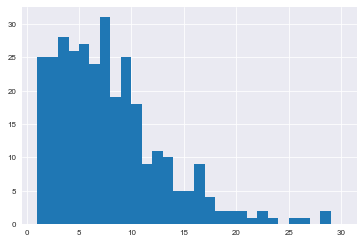

In [17]:
print("Unique Departments per order ranges from {} to {}"
      .format(dept_mix_df["unique_departments_in_cart"].min(),dept_mix_df["unique_departments_in_cart"].max()))
plt.hist(dept_mix_df["unique_departments_in_cart"],bins=range(1,31))
plt.show()

In [18]:
te = TransactionEncoder()
te_ary = te.fit(dept_mix_df["dept_mix"]).transform(dept_mix_df["dept_mix"],sparse=False)

df = pd.DataFrame(te_ary, columns=te.columns_)
min_support = 0.05
frequent_itemsets = apriori(df, min_support=min_support,use_colnames=True).sort_values(by='support',ascending=False)
print("Generated {} frequest itemsets using a minimum support of {}".format(len(frequent_itemsets),min_support))
frequent_itemsets.head()

Generated 144 frequest itemsets using a minimum support of 0.05


,support,itemsets
5,0.632911,[dairy eggs]
13,0.626582,[produce]
14,0.509494,[snacks]
46,0.436709,"[dairy eggs, produce]"
2,0.430380,[beverages]


In [19]:
confidence_min = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_min)
rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
rules.head()

print("Generated {} rules with minimum confidence {}".format(len(rules),confidence_min))
antecedent_max = 3
consequent_max = 3
confidence_min = 0.6
lift_min = 1.2

filtered_rules = rules[ (rules['antecedant_len'] <= antecedent_max ) &
               (rules['consequents_len'] <= consequent_max ) &
               (rules['confidence'] > confidence_min) &
               (rules['lift'] > lift_min) ]
print("Filtered {} rules to {} rules using filters [antecedent_max: {}, consequent_max: {}, confidence_min: {}, lift_min: {}]"
      .format(len(rules),len(filtered_rules),4,4,5,6))

filtered_rules.sort_values(by='lift',ascending=False).drop(['antecedant_len', 'consequents_len','antecedent support', 'consequent support'], axis=1).head(n=20)

Generated 234 rules with minimum confidence 0.5
Filtered 234 rules to 140 rules using filters [antecedent_max: 4, consequent_max: 4, confidence_min: 5, lift_min: 6]


,antecedants,consequents,support,confidence,lift,leverage,conviction
225,"(canned goods, dairy eggs)",(pantry),0.050633,0.666667,2.569106,0.030925,2.221519
179,"(dry goods pasta, dairy eggs)",(pantry),0.056962,0.666667,2.569106,0.034790,2.221519
168,"(deli, bakery)","(snacks, dairy eggs, produce)",0.056962,0.620690,2.547246,0.034600,1.993959
233,"(frozen, bakery)","(snacks, dairy eggs, produce)",0.050633,0.615385,2.525475,0.030584,1.966456
182,"(canned goods, produce)",(pantry),0.056962,0.642857,2.477352,0.033969,2.073418
221,"(dry goods pasta, produce)",(pantry),0.050633,0.640000,2.466341,0.030103,2.056962
196,"(deli, beverages)","(snacks, produce)",0.050633,0.727273,2.209790,0.027720,2.459916
211,"(bakery, meat seafood)","(dairy eggs, produce)",0.050633,0.941176,2.155158,0.027139,9.575949
156,"(frozen, bakery)","(snacks, produce)",0.056962,0.692308,2.103550,0.029883,2.180380
136,"(deli, bakery)","(snacks, produce)",0.063291,0.689655,2.095491,0.033088,2.161744


In [20]:
filtered_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedant_len,consequents_len
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,0.103345,0.546948,0.082233,0.812755,1.539415,0.025788,inf,2.200000,1.221429
std,0.051298,0.112977,0.039048,0.106361,0.311545,0.012044,NaN,0.625593,0.449906
min,0.050633,0.243671,0.050633,0.605263,1.203810,0.008572,1.360040,1.000000,1.000000
25%,0.069620,0.509494,0.056962,0.727273,1.334033,0.017996,1.959923,2.000000,1.000000
50%,0.082278,0.626582,0.063291,0.819347,1.436364,0.023038,2.413201,2.000000,1.000000
75%,0.120253,0.626582,0.096519,0.900000,1.595960,0.030759,3.752848,3.000000,1.000000
max,0.243671,0.632911,0.218354,1.000000,2.569106,0.086625,inf,3.000000,3.000000


Interpretation : 
- Product Mix of products suggests that healthy food is bought together, yoghurts and fruits, this data isn't particularly surprising or useful
- Product Mix at an aisle level seems to be suggesting breakfast/lunch patterns. (lunch meat, fresh fruits) -> (yogurt)	looks to me like a standard packed lunch, maybe more common at school age. (energy granola bars) -> (fresh fruits) looks more like a breakfast on the go, maybe more common for adults. I would put coffee near the energy bars, and maybe have snacks or meal deal posters near the lunch meats to promote sales of things like crisps to go with the sandwiches the consumers are presumably making.
- Product Mix at a department level looks to me like it is also pushing lunch patterns, (deli, beverages) -> (produce, snacks) is probably referencing more 'adult' lunches (breakfast roll, crisps and a drink?). However this is not suprising or particulary useful.